# **PROYECTO: Autoencoders Determinísticos**

## **0. Importación de librerías**

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import time

torch.manual_seed(0)
np.random.seed(0)

## **1. Preparación de los datos**

In [30]:
# Importamos el dataset MNIST tanto para train como para test y preparamos los loaders
mnist_train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

mnist_train_loader = DataLoader(mnist_train_data, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test_data, batch_size=64, shuffle=False)

# Importamos el dataset FMNIST tanto para train como para test y preparamos los loaders
fmnist_train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
fmnist_test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())

fmnist_train_loader = DataLoader(fmnist_train_data, batch_size=64, shuffle=True)
fmnist_test_loader = DataLoader(fmnist_test_data, batch_size=64, shuffle=False)

torch.Size([64, 1, 28, 28]) torch.Size([64])


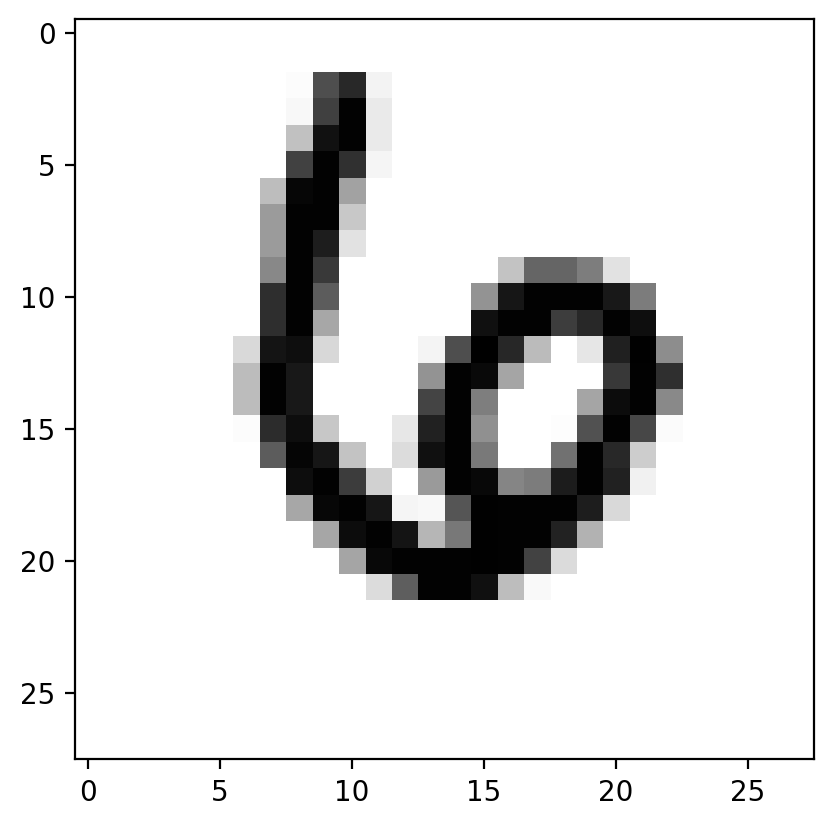

In [31]:
# Mostramos un ejemplo del dataset MNIST
batch_data, batch_labels = next(iter(mnist_train_loader))
print(batch_data.shape, batch_labels.shape)
plt.imshow(batch_data[0].numpy().squeeze(), cmap='gray_r')

torch.Size([64, 1, 28, 28]) torch.Size([64])


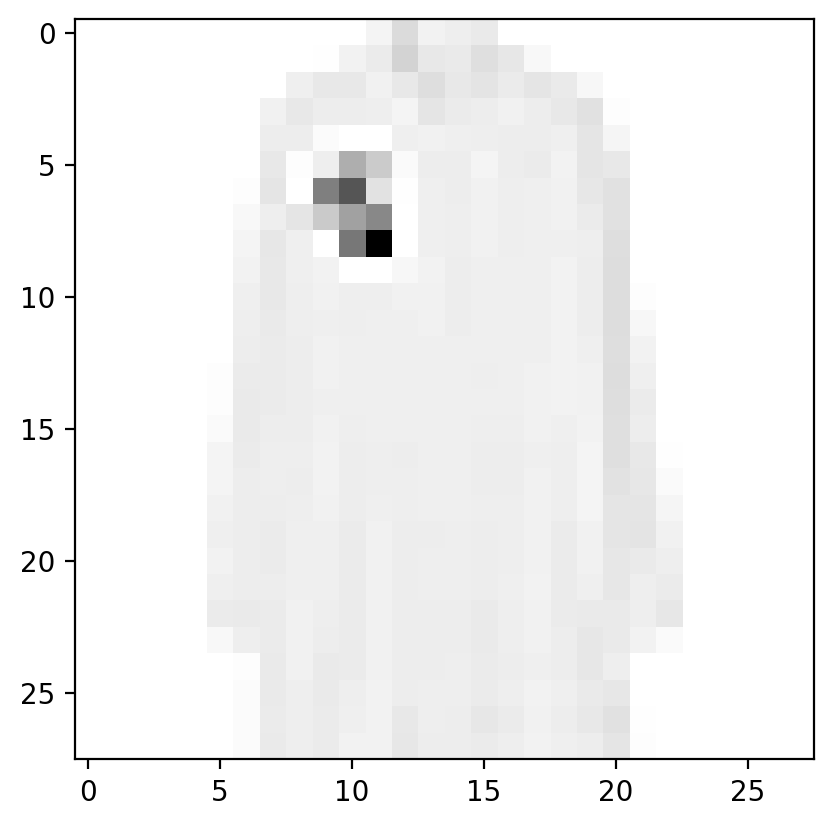

In [32]:
# Mostramos un ejemplo del dataset FMNIST
batch_data, batch_labels = next(iter(fmnist_train_loader))
print(batch_data.shape, batch_labels.shape)
plt.imshow(batch_data[0].numpy().squeeze(), cmap='gray_r')

In [33]:
# Calcula el tamaño para los conjuntos de train y validacion
train_size = int(0.8 * len(mnist_train_data))
valid_size = len(mnist_train_data) - train_size

# Obtener los subconjuntos de train y validacion para MNIST
mnist_train_subset, mnist_valid_subset = random_split(mnist_train_data, [train_size, valid_size])

# DataLoaders para train y validacion de MNIST
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_subset, batch_size=64, shuffle=True, num_workers=2)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid_subset, batch_size=64, shuffle=False, num_workers=2)

# Obtener los subconjuntos de train y validacion para FMNIST
fmnist_train_subset, fmnist_valid_subset = random_split(fmnist_train_data, [train_size, valid_size])

# DataLoaders para train y validacion para FMNIST
fmnist_train_loader = torch.utils.data.DataLoader(fmnist_train_subset, batch_size=64, shuffle=True, num_workers=2)
fmnist_valid_loader = torch.utils.data.DataLoader(fmnist_valid_subset, batch_size=64, shuffle=False, num_workers=2)

## **2. Preparación de Arquitecturas**

In [34]:
class Autoencoder(nn.Module):
    def __init__(self,
                 input_dim=784,            # 28 * 28 para MNIST/FMNIST
                 C=15,                     # Dimensión del espacio latente (z)
                 dropout_p=0.0,            # Probabilidad de Dropout (0.0 para desactivado)
                 weight_decay=0.0,         # Coeficiente L2 para el optimizador (0.0 para desactivado)
                 l1_lambda=0.0,            # Coeficiente L1 manual (0.0 para desactivado)
                 epochs=15,
                 lr=1e-3,
                 patience=3):

        super().__init__()

        # Parámetros y Regularización
        self.input_dim = input_dim
        self.C = C
        self.dropout_p = dropout_p
        self.l1_lambda = l1_lambda
        self.lr = lr
        self.epochs = epochs
        self.patience = patience

        # Variables para seguimiento
        self.loss_during_training = []
        self.psnr_during_training = []
        self.valid_loss_during_training = []
        self.valid_psnr_during_training = []

    # -----------------------------------------------------------
    # MÉTODOS DE ENTRENAMIENTO Y EVALUACIÓN
    # -----------------------------------------------------------

    def trainloop(self, trainloader, validloader):

        best_val_psnr = float('-inf') # Mejor PSNR es el valor más alto
        epochs_no_improve = 0
        best_model_state = None

        for e in range(int(self.epochs)):

            running_loss = 0.
            start_time = time.time()
            self.train()

            for images, _ in trainloader:

                labels = images # El autoencoder se entrena para reconstruir la entrada
                images, labels = images.to(self.device), labels.to(self.device)

                self.optim.zero_grad()

                out, _ = self.forward(images)

                # Cálculo de la pérdida
                loss = self.criterion(out, labels)

                # Regularización L1 manual
                if self.l1_lambda > 0:
                    l1_norm = sum(p.abs().sum() for p in self.parameters())
                    loss = loss + self.l1_lambda * l1_norm

                running_loss += loss.item()

                loss.backward()
                self.optim.step()


            # Loss del entrenamiento
            train_loss = running_loss/len(trainloader)
            self.loss_during_training.append(train_loss)

            # Evaluacion con la metrica PSNR del entrenamiento
            train_psnr = self.eval_performance(trainloader)
            self.psnr_during_training.append(train_psnr)

            # Loss de la validacion
            val_loss = self.eval_loss(validloader)
            self.valid_loss_during_training.append(val_loss)

            # Evaluación con la métrica PSNR de la validacion
            val_psnr = self.eval_performance(validloader)
            self.valid_psnr_during_training.append(val_psnr)

            time_per_epoch = time.time() - start_time
            #print("Epoch %d. Training loss: %.4f | Training PSNR: %.2f dB | Validation loss: %.4f | Validation PSNR: %.2f dB | Time: %.2f s"
            #         %(e, train_loss, train_psnr, val_loss, val_psnr, time_per_epoch))

            # Early Stopping (basado en PSNR)
            if val_psnr > best_val_psnr:
                best_val_psnr = val_psnr
                epochs_no_improve = 0
                best_model_state = self.state_dict()
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    print(f"\nEarly stopping activado en epoch {e}. PSNR no mejoró por {self.patience} épocas.")
                    if best_model_state:
                        self.load_state_dict(best_model_state)
                    break


    def eval_loss(self, dataloader):
        """
        Función de Evaluación de Pérdida
        """
        self.eval() # Cambia a modo evaluación
        running_loss = 0

        with torch.no_grad():
            for images, labels in dataloader:
                labels = images

                images, labels = images.to(self.device), labels.to(self.device)

                out = self.forward(images)[0]

                loss =  self.criterion(out, labels)

                running_loss += loss.item()

        self.train() # Cambia a modo entrenamiento
        return running_loss/len(dataloader)


    def eval_performance(self, dataloader):
        """
        Función de Evaluación de Rendimiento: Calcula el PSNR promedio.
        """
        self.eval() # Cambia a modo evaluacion
        running_psnr = 0
        batch_count = 0

        with torch.no_grad():
            for images, _ in dataloader:
                labels = images

                images, labels = images.to(self.device), labels.to(self.device)

                out, _ = self.forward(images) # Reconstrucción

                # Cálculo del PSNR: compara la imagen original con la reconstruida
                psnr = self.calculate_psnr(labels, out)

                running_psnr += psnr
                batch_count += 1

        self.train() # Cambia de nuevo al modo entrenamiento
        return running_psnr / batch_count

    @staticmethod
    def calculate_psnr(img_true, img_pred, max_val=1.0):
        """
        Calcula el Peak Signal-to-Noise Ratio (PSNR) entre dos imágenes/tensores.
        """
        # Asegurarse de que los tensores son del mismo tamaño y aplanar
        img_true = img_true.view(img_true.size(0), -1)
        img_pred = img_pred.view(img_pred.size(0), -1)

        # Calcular el Error Cuadrático Medio (MSE) por muestra
        mse = torch.mean((img_true - img_pred) ** 2, dim=1)

        # Evitar logaritmo de cero
        mse[mse == 0] = 1e-10

        # Calcular PSNR
        psnr = 10 * torch.log10(max_val**2 / mse)

        # Retornar el PSNR promedio del batch
        return torch.mean(psnr).item()

In [35]:

class LinealAutoencoder(Autoencoder):
    def __init__(self, n_layers=3, hidden_size=128, input_dim=784, C=15, dropout_p=0,
                 weight_decay=0, l1_lambda=0, epochs=15, lr=1e-3, patience=3):

        super().__init__(input_dim=input_dim, C=C, dropout_p=dropout_p,
                         weight_decay=weight_decay, l1_lambda=l1_lambda,
                         epochs=epochs, lr=lr, patience=patience)

        # -------------------
        # 1. ENCODER
        # -------------------
        encoder_layers = []
        # Definición de las dimensiones: [784, 128, 64, 32] si n_layers=3 y hidden_size=128
        dims = [input_dim] + [hidden_size // (2**i) for i in range(n_layers)]

        # Múltiples capas ocultas (desde la entrada hasta la penúltima)
        for i in range(n_layers):
            encoder_layers.append(nn.Linear(dims[i], dims[i+1]))
            encoder_layers.append(nn.BatchNorm1d(dims[i+1]))
            encoder_layers.append(nn.ReLU())
            if dropout_p > 0:
                encoder_layers.append(nn.Dropout(dropout_p))

        # Capa final al espacio latente (Cuello de Botella)
        # NOTA: No se aplica BatchNorm1d ni ReLU después de la capa latente
        encoder_layers.append(nn.Linear(dims[-1], C))
        self.encoder = nn.Sequential(*encoder_layers)

        # -------------------
        # 2. DECODER
        # -------------------
        decoder_layers = []

        # Las dimensiones son las del Encoder al revés: [C, 32, 64, 128, 784]
        # decoder_dims_hidden = [C] + dims[1:][::-1]  # [C, 32, 64, 128]
        # La secuencia de dimensiones internas es: [C, 32, 64, 128] -> [32, 64, 128, 784]

        # Las dimensiones de entrada/salida para las n_layers capas internas del decoder
        # La entrada es el espacio latente C. La salida es input_dim (784).

        # Las dimensiones de los 'bloques' del decoder: C -> dims[-1] -> ... -> dims[1] -> input_dim
        # Los bloques son simétricos a los del encoder, pero invirtiendo las conexiones:
        # Encoder: (dim[i] -> dim[i+1])
        # Decoder: (dim[i+1] -> dim[i])

        # Lista de dimensiones: [32, 64, 128] (n_layers=3)
        dims_rev = dims[1:][::-1]

        # Primera capa del Decoder (desde el espacio latente C)
        decoder_layers.append(nn.Linear(C, dims_rev[0]))
        decoder_layers.append(nn.BatchNorm1d(dims_rev[0]))
        decoder_layers.append(nn.ReLU())
        if dropout_p > 0:
             decoder_layers.append(nn.Dropout(dropout_p))

        # Capas ocultas intermedias (simétricas al codificador)
        for i in range(n_layers - 1):
            decoder_layers.append(nn.Linear(dims_rev[i], dims_rev[i+1]))
            decoder_layers.append(nn.BatchNorm1d(dims_rev[i+1]))
            decoder_layers.append(nn.ReLU())
            if dropout_p > 0:
                decoder_layers.append(nn.Dropout(dropout_p))

        # Capa final al tamaño de la entrada (n_layers-ésima capa)
        # Conexión: del último tamaño oculto (dims_rev[-1]) a input_dim
        decoder_layers.append(nn.Linear(dims_rev[-1], input_dim))

        # Usamos Sigmoid para restringir la salida entre [0, 1]
        # (Esto es crucial para imágenes normalizadas como MNIST/FMNIST)
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

        # Mueve todo a la GPU si esta disponible
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

        # Inicialización de Optimizador y Pérdida
        self.optim = optim.Adam(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        # MSELoss (Mean Squared Error) es el estándar para autoencoders de reconstrucción
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # Asume entrada x con forma (batch_size, 1, 28, 28)

        # Aplana la entrada
        batch_size = x.size(0)
        x_flattened = x.view(batch_size, -1) # -> (batch_size, 784)

        # Codificador: x_flattened -> z
        latent = self.encoder(x_flattened) # -> (batch_size, C)

        # Decodificador: z -> x_flat
        x_flat = self.decoder(latent) # -> (batch_size, 784)

        # Remodela la salida a la forma de la imagen original
        # (batch_size, 784) -> (batch_size, 1, 28, 28)
        x_reconstructed = x_flat.view(batch_size, 1, 28, 28)

        return x_reconstructed, latent


In [36]:
# Autoencoder Convolucional
class ConvAutoencoder(Autoencoder):
    def __init__(self, C=15, dropout_p=0.0, weight_decay=0.0, l1_lambda=0.0, epochs=15, lr=1e-3, patience=3):

        super().__init__(input_dim=784, C=C, dropout_p=dropout_p,
                         weight_decay=weight_decay, l1_lambda=l1_lambda,
                         epochs=epochs, lr=lr, patience=patience)

    def forward(self, x):
        latent = self.encoder(x)
        x_reconstructed_img = self.decoder(latent)

        return x_reconstructed_img, latent

    def insert_dropout(self, layers, dropout_p):
        # Inserta dropout despues de cada capa
        result = []
        for layer in layers:
            result.append(layer)
            result.append(nn.Dropout2d(dropout_p))
        return result

In [37]:
class ThreeLayersConvAutoencoder(ConvAutoencoder):
  def __init__(self, in_channels=1, C=15, kernel_size=3, padding=1,
                 stride=1, dropout_p=0.0, weight_decay=0.0, l1_lambda=0.0,
                 epochs=15, lr=1e-3, patience=3):

        super().__init__(C=C, dropout_p=dropout_p,
                         weight_decay=weight_decay, l1_lambda=l1_lambda,
                         epochs=epochs, lr=lr, patience=patience)

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        # Progresión de canales: 1 -> C/4 -> C/2 -> C
        C_div_4 = C // 4
        C_div_2 = C // 2
        C_final = C

        # -----------------------------------------------
        # 1. ENCODER
        # -----------------------------------------------

        # Layer 1: 28x28x1 -> 14x14x(C/4)
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels, C_div_4, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(C_div_4), nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        # Layer 2: 14x14x(C/4) -> 7x7x(C/2)
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(C_div_4, C_div_2, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(C_div_2), nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        # Layer 3: 7x7x(C/2) -> 3x3x(C)
        self.encoder_layer3 = nn.Sequential(
            nn.Conv2d(C_div_2, C_final, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(C_final), nn.ReLU(True),
            nn.MaxPool2d(2, 2) # Asumiendo que 7x7 con k=3, p=1, s=1 -> 7x7. Luego MaxPool2d(2,2) -> 3x3 (o 4x4, dependiendo del borde)
        )

        # Combinar el encoder
        encoder_layers = [self.encoder_layer1, self.encoder_layer2, self.encoder_layer3]
        if dropout_p > 0:
            self.encoder = nn.Sequential(
                *self.insert_dropout(encoder_layers, dropout_p)
            )
        else:
            self.encoder = nn.Sequential(*encoder_layers)

        # Definición del Espacio Latente
        self.latent_channels = C_final
        self.latent_spatial_dim = 3 # Asumiendo 3x3 después de las capas de pooling.

        # ---------------------------------------------------------------------
        # 2. DECODER (Ajustado)
        # ---------------------------------------------------------------------

        # Layer 1 ConvTranspose: C -> C/2. Spatial: 3x3 -> 7x7
        self.decoder_layer1 = nn.Sequential(
            nn.ConvTranspose2d(C_final, C_div_2, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(C_div_2), nn.ReLU(True)
        )

        # Layer 2 ConvTranspose: C/2 -> C/4. Spatial: 7x7 -> 14x14
        self.decoder_layer2 = nn.Sequential(
            nn.ConvTranspose2d(C_div_2, C_div_4, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(C_div_4), nn.ReLU(True)
        )

        # Layer 3 ConvTranspose: C/4 -> in_channels. Spatial: 14x14 -> 28x28
        # Esta capa es la que produce la imagen final.
        self.decoder_layer3 = nn.Sequential(
            nn.ConvTranspose2d(C_div_4, in_channels, kernel_size=2, stride=2, padding=0),
            # ¡CLAVE!: Eliminamos BatchNorm2d y ReLU de la última capa de transpuesta,
            # ya que la Sigmoid se aplicará inmediatamente después para la reconstrucción.
            # nn.BatchNorm2d(in_channels), nn.ReLU(True)
        )

        # Capa Conv2d Final y Activación (Ajuste)
        # Se mantiene la convolución 1x1 por si quieres un ajuste fino de canales/dimensiones,
        # aunque es opcional si decoder_layer3 ya va a in_channels=1.
        self.decoder_final_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0, stride=1)
        self.decoder_final_act = nn.Sigmoid()

        # Combinar el decoder (añadiendo Dropout si aplica)
        decoder_layers = [self.decoder_layer1, self.decoder_layer2, self.decoder_layer3]
        if dropout_p > 0:
            self.decoder = nn.Sequential(
                *self.insert_dropout(decoder_layers, dropout_p),
                self.decoder_final_conv,
                self.decoder_final_act
            )
        else:
            self.decoder = nn.Sequential(
                *decoder_layers,
                self.decoder_final_conv,
                self.decoder_final_act
            )

        # Inicialización de Optimizador y Pérdida
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.optim = optim.Adam(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()

In [38]:
class FiveLayersConvAutoencoder(ConvAutoencoder):
  def __init__(self, in_channels=1, C=15, kernel_size=3, padding=1,
                 stride=1, dropout_p=0.0, weight_decay=0.0, l1_lambda=0.0,
                 epochs=15, lr=1e-3, patience=3):

        super().__init__(C=C, dropout_p=dropout_p,
                         weight_decay=weight_decay, l1_lambda=l1_lambda,
                         epochs=epochs, lr=lr, patience=patience)

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        # Progresión de canales
        C_intermedio_1 = 8
        C_intermedio_2 = 16
        C_intermedio_3 = 32
        C_intermedio_4 = 64
        C_final = C

        # -----------------------------------------------
        ## 1. ENCODER
        # -----------------------------------------------

        # Layer 1: 28x28x1 -> 14x14x8
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels, C_intermedio_1, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(C_intermedio_1), nn.ReLU(True), nn.MaxPool2d(2, 2)
        )
        # Layer 2: 14x14x8 -> 7x7x16
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(C_intermedio_1, C_intermedio_2, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(C_intermedio_2), nn.ReLU(True), nn.MaxPool2d(2, 2)
        )
        # Layer 3: 7x7x16 -> 3x3x32
        self.encoder_layer3 = nn.Sequential(
            nn.Conv2d(C_intermedio_2, C_intermedio_3, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(C_intermedio_3), nn.ReLU(True), nn.MaxPool2d(2, 2)
        )
        # Layer 4: 3x3x32 -> 1x1x64
        self.encoder_layer4 = nn.Sequential(
            nn.Conv2d(C_intermedio_3, C_intermedio_4, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.BatchNorm2d(C_intermedio_4), nn.ReLU(True), nn.MaxPool2d(2, 2)
        )
        # Layer 5 (Latente): 1x1x64 -> 1x1xC (Proyección de canales)
        # Se mantiene BatchNorm2d y ReLU aquí, ya que es el final del encoder.
        self.encoder_layer5 = nn.Sequential(
            nn.Conv2d(C_intermedio_4, C_final, kernel_size=1, padding=0, stride=1),
            nn.BatchNorm2d(C_final), nn.ReLU(True)
        )

        # Definición del Espacio Latente
        self.latent_channels = C_final
        self.latent_spatial_dim = 1

        encoder_layers = [self.encoder_layer1, self.encoder_layer2, self.encoder_layer3, self.encoder_layer4, self.encoder_layer5]
        self.encoder = nn.Sequential(*self.insert_dropout(encoder_layers, dropout_p)) if dropout_p > 0 else nn.Sequential(*encoder_layers)

        # ---------------------------------------------------------------------
        ## 2. DECODER (Ajustado)
        # ---------------------------------------------------------------------

        # Layer 1 ConvTranspose: C -> 64. Spatial: 1x1 -> 1x1 (Proyección de canales inversa)
        self.decoder_layer1 = nn.Sequential(
            nn.ConvTranspose2d(C_final, C_intermedio_4, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(C_intermedio_4), nn.ReLU(True)
        )
        # Layer 2 ConvTranspose: 64 -> 32. Spatial: 1x1 -> 3x3
        self.decoder_layer2 = nn.Sequential(
            nn.ConvTranspose2d(C_intermedio_4, C_intermedio_3, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(C_intermedio_3), nn.ReLU(True)
        )
        # Layer 3 ConvTranspose: 32 -> 16. Spatial: 3x3 -> 7x7
        self.decoder_layer3 = nn.Sequential(
            nn.ConvTranspose2d(C_intermedio_3, C_intermedio_2, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(C_intermedio_2), nn.ReLU(True)
        )
        # Layer 4 ConvTranspose: 16 -> 8. Spatial: 7x7 -> 14x14
        self.decoder_layer4 = nn.Sequential(
            nn.ConvTranspose2d(C_intermedio_2, C_intermedio_1, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(C_intermedio_1), nn.ReLU(True)
        )
        # Layer 5 ConvTranspose: 8 -> in_channels. Spatial: 14x14 -> 28x28
        # ¡CORRECCIÓN CLAVE!: Se eliminan BatchNorm2d y ReLU de esta capa final.
        self.decoder_layer5 = nn.Sequential(
            nn.ConvTranspose2d(C_intermedio_1, in_channels, kernel_size=2, stride=2, padding=0),
        )

        # Capa Conv2d Final (Ajuste de canales: 1 -> 1)
        self.decoder_final_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0, stride=1)
        self.decoder_final_act = nn.Sigmoid()

        # Combinamos las capas intermedias para el Dropout. Excluimos las capas finales de reconstrucción.
        decoder_intermediate_layers = [
            self.decoder_layer1, self.decoder_layer2, self.decoder_layer3, self.decoder_layer4, self.decoder_layer5
        ]

        if dropout_p > 0:
            decoder_sequence = self.insert_dropout(decoder_intermediate_layers, dropout_p) + [self.decoder_final_conv, self.decoder_final_act]
            self.decoder = nn.Sequential(*decoder_sequence)
        else:
            self.decoder = nn.Sequential(
                *decoder_intermediate_layers,
                self.decoder_final_conv,
                self.decoder_final_act
            )

        # Inicialización de Optimizador y Pérdida
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.optim = optim.Adam(self.parameters(), lr=self.lr, weight_decay=weight_decay)
        self.criterion = nn.MSELoss()

## **3. Entrenamiento y Evaluación**

In [39]:
# Probabilidad de Dropout
DROPOUT_P = 0.2
# Hiperparámetro para la penalización L1 (sparsity)
L1_LAMBDA = 1e-5
# Hiperparámetro para la penalización L2 (weight decay)
L2_LAMBDA = 1e-4
# Hidden size para modelos lineales de 5 capas
HIDDEN_SIZE_5_LAYERS = 256

In [40]:
# Funcion para entrenar y evaluar los modelos
def train_eval_autoencoders(autoencoders, train_loader, valid_loader, test_loader):
    model_eval = {}

    # Entrenamiento y evaluacion de los modelos
    for autoencoder_name, autoencoder in autoencoders.items():
        # Entrena el modelo
        autoencoder.trainloop(train_loader, valid_loader)

        # Crea la figura
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

        # Titulo de la figura
        fig.suptitle(autoencoder_name, fontsize=14, fontweight='bold')

        # Grafica PSNR
        ax1.plot(autoencoder.psnr_during_training, label='Training PSNR')
        ax1.plot(autoencoder.valid_psnr_during_training, label='Validation PSNR')

        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('PSNR (dB)')
        ax1.legend()
        ax1.grid(True)

        # Grafica Loss
        ax2.plot(autoencoder.loss_during_training, label='Training Loss')
        ax2.plot(autoencoder.valid_loss_during_training, label='Validation Loss')

        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss (MSE)')
        ax2.legend()
        ax2.grid(True)

        # Muestra la figura
        plt.tight_layout()
        plt.show()

        # Evalua al modelo
        model_eval[autoencoder_name] = autoencoder.eval_performance(test_loader)

    return pd.DataFrame.from_dict(model_eval, orient='index', columns=['PSNR'])

### *Evaluación sobre MNIST*

In [41]:
# --------------------------------------------------------
# CONFIGURACIONES DE LOS MODELOS
# --------------------------------------------------------
autoencoders_mnist = {
    # --------------------------------------------------------
    # I. AUTOENCODERS LINEALES (MLP-AE)
    # --------------------------------------------------------
    'Linear Base 3L C30': LinealAutoencoder(n_layers=3, C=30),
    'Linear Base 5L C30': LinealAutoencoder(n_layers=5, C=30, hidden_size=HIDDEN_SIZE_5_LAYERS),

    'Linear C15 L1': LinealAutoencoder(n_layers=3, C=15, l1_lambda=L1_LAMBDA),
    'Linear C100 DO': LinealAutoencoder(n_layers=5, C=100, hidden_size=HIDDEN_SIZE_5_LAYERS, dropout_p=DROPOUT_P),

    'Linear C50 L2': LinealAutoencoder(n_layers=3, C=50, weight_decay=L2_LAMBDA),
    'Linear C100 L2+DO': LinealAutoencoder(n_layers=5, C=100, hidden_size=HIDDEN_SIZE_5_LAYERS, weight_decay=L2_LAMBDA, dropout_p=DROPOUT_P),
    'Linear C50 L1+L2': LinealAutoencoder(n_layers=3, C=50, l1_lambda=L1_LAMBDA, weight_decay=L2_LAMBDA),

    # --------------------------------------------------------
    # II. AUTOENCODERS CONVOLUCIONALES (Conv-AE)
    # --------------------------------------------------------
    'Conv Base 3L C15': ThreeLayersConvAutoencoder(C=15),
    'Conv Base 3L C100': ThreeLayersConvAutoencoder(C=100),
    'Conv Base 5L C15': FiveLayersConvAutoencoder(C=15),
    'Conv Base 5L C100': FiveLayersConvAutoencoder(C=100),

    'Conv L1 3L C30': ThreeLayersConvAutoencoder(C=30, l1_lambda=L1_LAMBDA),
    'Conv L1 5L C100': FiveLayersConvAutoencoder(C=100, l1_lambda=L1_LAMBDA),

    'Conv DO 3L C30': ThreeLayersConvAutoencoder(C=30, dropout_p=DROPOUT_P),
    'Conv DO 5L C100': FiveLayersConvAutoencoder(C=100, dropout_p=DROPOUT_P),

    'Conv L2 3L C50': ThreeLayersConvAutoencoder(C=50, weight_decay=L2_LAMBDA),
    'Conv L2 5L C100': FiveLayersConvAutoencoder(C=100, weight_decay=L2_LAMBDA),

    'Conv L1+DO 3L C50': ThreeLayersConvAutoencoder(C=50, l1_lambda=L1_LAMBDA, dropout_p=DROPOUT_P),
    'Conv L2+DO 5L C50': FiveLayersConvAutoencoder(C=50, weight_decay=L2_LAMBDA, dropout_p=DROPOUT_P),
    'Conv L1+L2 3L C50': ThreeLayersConvAutoencoder(C=50, l1_lambda=L1_LAMBDA, weight_decay=L2_LAMBDA),
}

In [42]:
 # Se entrenan y evaluan los modelos sobre MNIST
mnist_eval = train_eval_autoencoders(autoencoders_mnist, mnist_train_loader, mnist_valid_loader, mnist_test_loader)

# Se muestran los resultados de PSNR para cada modelo
display(mnist_eval)

Output hidden; open in https://colab.research.google.com to view.

### *Evaluación sobre FMNIST*

In [43]:
# --------------------------------------------------------
# CONFIGURACIONES DE LOS MODELOS
# --------------------------------------------------------
autoencoders_fmnist = {
    # --------------------------------------------------------
    # I. AUTOENCODERS LINEALES (MLP-AE)
    # --------------------------------------------------------
    'Linear Base 3L C30': LinealAutoencoder(n_layers=3, C=30),
    'Linear Base 5L C30': LinealAutoencoder(n_layers=5, C=30, hidden_size=HIDDEN_SIZE_5_LAYERS),

    'Linear C15 L1': LinealAutoencoder(n_layers=3, C=15, l1_lambda=L1_LAMBDA),
    'Linear C100 DO': LinealAutoencoder(n_layers=5, C=100, hidden_size=HIDDEN_SIZE_5_LAYERS, dropout_p=DROPOUT_P),

    'Linear C50 L2': LinealAutoencoder(n_layers=3, C=50, weight_decay=L2_LAMBDA),
    'Linear C100 L2+DO': LinealAutoencoder(n_layers=5, C=100, hidden_size=HIDDEN_SIZE_5_LAYERS, weight_decay=L2_LAMBDA, dropout_p=DROPOUT_P),
    'Linear C50 L1+L2': LinealAutoencoder(n_layers=3, C=50, l1_lambda=L1_LAMBDA, weight_decay=L2_LAMBDA),

    # --------------------------------------------------------
    # II. AUTOENCODERS CONVOLUCIONALES (Conv-AE)
    # --------------------------------------------------------
    'Conv Base 3L C15': ThreeLayersConvAutoencoder(C=15),
    'Conv Base 3L C100': ThreeLayersConvAutoencoder(C=100),
    'Conv Base 5L C15': FiveLayersConvAutoencoder(C=15),
    'Conv Base 5L C100': FiveLayersConvAutoencoder(C=100),

    'Conv L1 3L C30': ThreeLayersConvAutoencoder(C=30, l1_lambda=L1_LAMBDA),
    'Conv L1 5L C100': FiveLayersConvAutoencoder(C=100, l1_lambda=L1_LAMBDA),

    'Conv DO 3L C30': ThreeLayersConvAutoencoder(C=30, dropout_p=DROPOUT_P),
    'Conv DO 5L C100': FiveLayersConvAutoencoder(C=100, dropout_p=DROPOUT_P),

    'Conv L2 3L C50': ThreeLayersConvAutoencoder(C=50, weight_decay=L2_LAMBDA),
    'Conv L2 5L C100': FiveLayersConvAutoencoder(C=100, weight_decay=L2_LAMBDA),

    'Conv L1+DO 3L C50': ThreeLayersConvAutoencoder(C=50, l1_lambda=L1_LAMBDA, dropout_p=DROPOUT_P),
    'Conv L2+DO 5L C50': FiveLayersConvAutoencoder(C=50, weight_decay=L2_LAMBDA, dropout_p=DROPOUT_P),
    'Conv L1+L2 3L C50': ThreeLayersConvAutoencoder(C=50, l1_lambda=L1_LAMBDA, weight_decay=L2_LAMBDA),
}


Early stopping activado en epoch 14. PSNR no mejoró por 3 épocas.


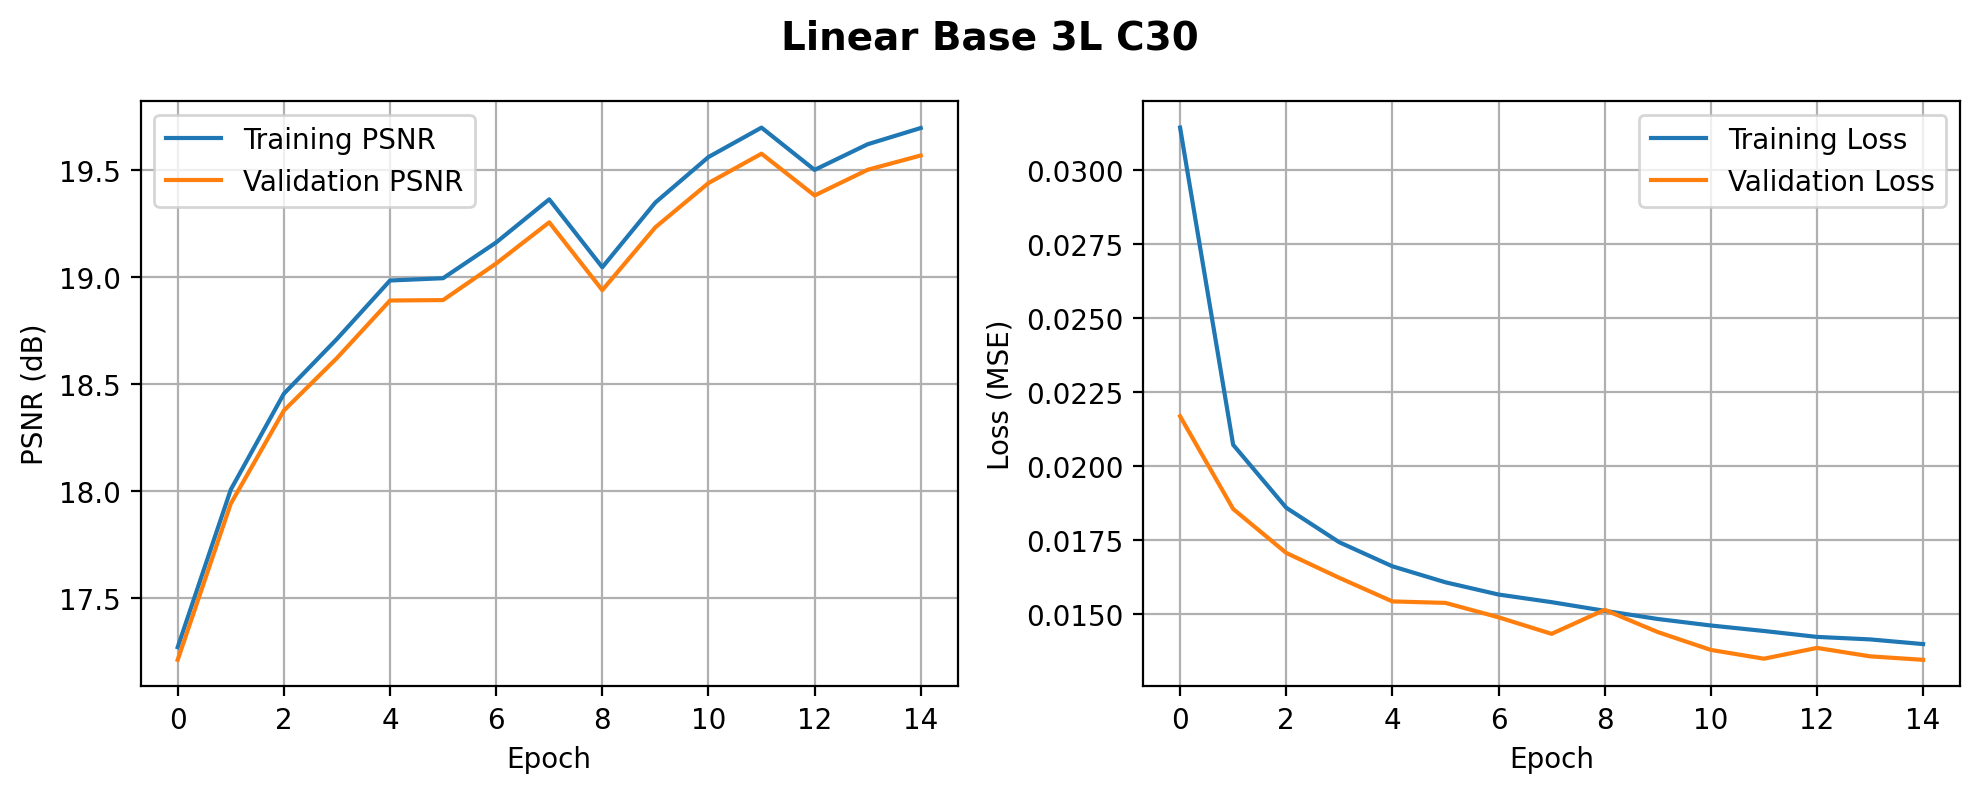

In [ ]:
# Se entrenan y evaluan los modelos sobre FMNIST
fmnist_eval = train_eval_autoencoders(autoencoders_fmnist, fmnist_train_loader, fmnist_valid_loader, fmnist_test_loader)

# Se muestran los resultados de PSNR para cada modelo
display(fmnist_eval)

## **4. Autoencoder para Denoising**

In [ ]:
# Esta clase hereda de la clase con la mejor arquitectura encontrada
class DenoisingAutoencoder(ThreeLayersConvAutoencoder):
  def __init__(self, in_channels=1, C=15, kernel_size=3, padding=1,
                 stride=1, dropout_p=0.0, weight_decay=0.0, l1_lambda=0.0,
                 epochs=10, lr=1e-3, patience=2, variance=0.2):

        super().__init__(in_channels=in_channels, C=C, kernel_size=kernel_size, padding=padding, stride=1,
                         dropout_p=dropout_p, weight_decay=weight_decay, l1_lambda=l1_lambda, epochs=epochs,
                         lr=lr, patience=patience)

        self.variance = variance

  @staticmethod
  def add_gaussian_noise(images, variance):
    """
    Añade ruido gaussiano aditivo de media cero, controlando la intensidad mediante la varianza
    """
    # 1. Calcular la Desviación Estándar (sigma) a partir de la Varianza (sigma^2)
    # sigma = sqrt(variance)
    std_dev = torch.sqrt(torch.tensor(variance, dtype=images.dtype, device=images.device))

    # 2. Generar ruido con media 0 y desviación estándar 1 (Normal Estándar)
    noise = torch.randn_like(images)

    # 3. Ajustar la desviación estándar y añadir el ruido
    noisy_images = images + (std_dev * noise)

    # 4. Asegurar que los valores se mantengan entre 0 y 1
    noisy_images = torch.clamp(noisy_images, 0., 1.)

    return noisy_images

  # -----------------------------------------------------------
  # MÉTODOS DE ENTRENAMIENTO Y EVALUACIÓN
  # -----------------------------------------------------------

  def trainloop(self, trainloader, validloader):

      best_val_psnr = float('-inf') # Mejor PSNR es el valor más alto
      epochs_no_improve = 0
      best_model_state = None

      for e in range(int(self.epochs)):

          running_loss = 0.
          start_time = time.time()
          self.train()

          for images, _ in trainloader:

              labels = images # El autoencoder se entrena para reconstruir la entrada
              images, labels = images.to(self.device), labels.to(self.device)

              # Añade el ruido a las imagenes
              images = self.add_gaussian_noise(images, self.variance)

              self.optim.zero_grad()

              out, _ = self.forward(images)

              # Cálculo de la pérdida
              loss = self.criterion(out, labels)

              # Regularización L1 manual
              if self.l1_lambda > 0:
                  l1_norm = sum(p.abs().sum() for p in self.parameters())
                  loss = loss + self.l1_lambda * l1_norm

              running_loss += loss.item()

              loss.backward()
              self.optim.step()


          # Loss del entrenamiento
          train_loss = running_loss/len(trainloader)
          self.loss_during_training.append(train_loss)

          # Evaluacion con la metrica PSNR del entrenamiento
          train_psnr = self.eval_performance(trainloader)
          self.psnr_during_training.append(train_psnr)

          # Loss de la validacion
          val_loss = self.eval_loss(validloader)
          self.valid_loss_during_training.append(val_loss)

          # Evaluación con la métrica PSNR de la validacion
          val_psnr = self.eval_performance(validloader)
          self.valid_psnr_during_training.append(val_psnr)

          time_per_epoch = time.time() - start_time
          #print("Epoch %d. Training loss: %.4f | Training PSNR: %.2f dB | Validation loss: %.4f | Validation PSNR: %.2f dB | Time: %.2f s"
          #         %(e, train_loss, train_psnr, val_loss, val_psnr, time_per_epoch))

          # Early Stopping (basado en PSNR)
          if val_psnr > best_val_psnr:
              best_val_psnr = val_psnr
              epochs_no_improve = 0
              best_model_state = self.state_dict()
          else:
              epochs_no_improve += 1
              if epochs_no_improve >= self.patience:
                  print(f"\nEarly stopping activado en epoch {e}. PSNR no mejoró por {self.patience} épocas.")
                  if best_model_state:
                      self.load_state_dict(best_model_state)
                  break


  def eval_loss(self, dataloader):
      """
      Función de Evaluación de Pérdida
      """
      self.eval() # Cambia a modo evaluación
      running_loss = 0

      with torch.no_grad():
          for images, labels in dataloader:
              labels = images

              images, labels = images.to(self.device), labels.to(self.device)

              # Añade el ruido a las imagenes
              images = self.add_gaussian_noise(images, self.variance)

              out = self.forward(images)[0]

              loss =  self.criterion(out, labels)

              running_loss += loss.item()

      self.train() # Cambia a modo entrenamiento
      return running_loss/len(dataloader)


  def eval_performance(self, dataloader):
      """
      Función de Evaluación de Rendimiento: Calcula el PSNR promedio.
      """
      self.eval() # Cambia a modo evaluacion
      running_psnr = 0
      batch_count = 0

      with torch.no_grad():
          for images, _ in dataloader:
              labels = images

              images, labels = images.to(self.device), labels.to(self.device)

              # Añade el ruido a las imagenes
              images = self.add_gaussian_noise(images, self.variance)

              out, _ = self.forward(images) # Reconstrucción

              # Cálculo del PSNR: compara la imagen original con la reconstruida
              psnr = self.calculate_psnr(labels, out)

              running_psnr += psnr
              batch_count += 1

      self.train() # Cambia de nuevo al modo entrenamiento
      return running_psnr / batch_count

### *Evaluación sobre MNIST*

In [ ]:
# Se crean los modelos con los hiperparametros de la mejor arquitectura encontrada y cambiando la varianza
denoising_autoencoders_mnist = {
    'Denoising Autoencoder Var=0.01': DenoisingAutoencoder(variance=0.01, C=100),
    'Denoising Autoencoder Var=0.04': DenoisingAutoencoder(variance=0.04, C=100),
    'Denoising Autoencoder Var=0.09': DenoisingAutoencoder(variance=0.09, C=100),
    'Denoising Autoencoder Var=0.16': DenoisingAutoencoder(variance=0.16, C=100),
    'Denoising Autoencoder Var=0.25': DenoisingAutoencoder(variance=0.25, C=100),
}

In [ ]:
# Se entrenan y evaluan los modelos sobre MNIST
mnist_denoising_eval = train_eval_autoencoders(denoising_autoencoders_mnist, mnist_train_loader, mnist_valid_loader, mnist_test_loader)

# Se muestran los resultados de PSNR para cada modelo
display(mnist_denoising_eval)

### *Evaluación sobre FMNIST*

In [ ]:
# Se crean los modelos con los hiperparametros de la mejor arquitectura encontrada y cambiando la varianza
denoising_autoencoders_fmnist = {
    'Denoising Autoencoder Var=0.01': DenoisingAutoencoder(variance=0.01, C=100),
    'Denoising Autoencoder Var=0.04': DenoisingAutoencoder(variance=0.04, C=100),
    'Denoising Autoencoder Var=0.09': DenoisingAutoencoder(variance=0.09, C=100),
    'Denoising Autoencoder Var=0.16': DenoisingAutoencoder(variance=0.16, C=100),
    'Denoising Autoencoder Var=0.25': DenoisingAutoencoder(variance=0.25, C=100),
}

In [ ]:
# Se entrenan y evaluan los modelos sobre FMNIST
fmnist_denoising_eval = train_eval_autoencoders(denoising_autoencoders_fmnist, fmnist_train_loader, fmnist_valid_loader, fmnist_test_loader)

# Se muestran los resultados de PSNR para cada modelo
display(fmnist_denoising_eval)

## **5. Experimentos Adicionales**

### *Entrenamiento con diferentes tamaños de dataset*

### *Comparación entre representaciones buenas y malas*

In [ ]:
def show_comparison(autoencoders, evaluation, dataloader, num_images=5):
    """
    Muestra comparaciones entre imágenes originales y su mejor y peor reconstruccion
    """
    # Obtenemos el mejor y el peor modelo en terminos de PSNR
    best_autoencoder = autoencoders[evaluation['PSNR'].idxmax()]
    best_autoencoder.eval()
    worst_autoencoder = autoencoders[evaluation['PSNR'].idxmin()]
    worst_autoencoder.eval()

    # Obtenemos un batch de las imagenes de test
    dataiter = iter(dataloader)
    images, _ = next(dataiter)
    batch_size=64

    # Pasamos las imagenes y las etiquetas a gpu
    images_gpu = images.to(best_autoencoder.device)

    # Representacion latente del batch
    best_output, _ = best_autoencoder.forward(images_gpu)
    worst_output, _ = worst_autoencoder.forward(images_gpu)

    # Se ajusta la salida a un batch de imagenes
    best_output = best_output.view(batch_size, 1, 28, 28)
    worst_output = worst_output.view(batch_size, 1, 28, 28)

    # Movemos el resultado de vuelta a la cpu
    best_output = best_output.cpu().detach()
    worst_output = worst_output.cpu().detach()

    # Se imprimen las imagenes originales y las reconstrucciones de cada modelo
    fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,4))
    fig.suptitle('Comparación entre representaciones buenas y malas', fontsize=16, fontweight='bold')

    # Primero las imagenes originales y luego las reconstrucciones
    for i in range(num_images):
        axes[0,i].imshow(images[i,:,:,:])
        axes[1,i].imshow(best_output[i,:,:,:])
        axes[2,i].imshow(worst_output[i,:,:,:])

        # Elimina las leyendas
        axes[0,i].get_xaxis().set_visible(False)
        axes[0,i].get_yaxis().set_visible(False)
        axes[1,i].get_xaxis().set_visible(False)
        axes[1,i].get_yaxis().set_visible(False)
        axes[2,i].get_xaxis().set_visible(False)
        axes[2,i].get_yaxis().set_visible(False)

    # Titulos de las filas
    axes[0, 0].set_ylabel('Imágenes Originales', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Mejores Reconstrucciones', fontsize=12, fontweight='bold')
    axes[2, 0].set_ylabel('Peores Reconstrucciones', fontsize=12, fontweight='bold')

    # Vuelta a modo entrenamiento
    best_autoencoder.train()
    worst_autoencoder.train()


In [ ]:
# Muestra la comparacion para MNIST
show_comparison(autoencoders=autoencoders_mnist, evaluation=mnist_eval, dataloader=mnist_test_loader, num_images=10)

In [ ]:
# Muestra la comparacion para FMNIST
show_comparison(autoencoders=autoencoders_fmnist, evaluation=fmnist_eval, dataloader=fmnist_test_loader, num_images=10)

### *Entrenamiento con MNIST y testeo con FMNIST*

In [ ]:
autoencoders = {
    'Lineal Autoencoder': LinealAutoencoder(),
    'Three Layers Conv Autoencoder': ThreeLayersConvAutoencoder(),
    'Five Layers Conv Autoencoder': FiveLayersConvAutoencoder()
}

eval = train_eval_autoencoders(autoencoders=autoencoders, train_loader=mnist_train_loader, valid_loader=fmnist_valid_loader, test_loader=fmnist_test_loader)

### *Visualización de aprendizaje*

### *Encoder como generador de muestras*

## **6. Conclusiones**